## eye-tracking experiments

## TODO

- including more from data
    - distances
    - stimuli
    - gaze vector
- more derived features
    - interpolated blinks
    - actual blinks vs undetected
- X-fold
- CNN and other methods
    - adding external info (length, track ratio, etc)
    - CNN
    - Transformer
    - Attention
- overpadding and varied length problem

# load, import and stuff

In [30]:
import numpy as np
import pandas as pd
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


variables

In [145]:
# Model Parameters

max_time_length = 1000         # Max Length of the time series. there's an outlier with 60k frames while other ones has like no more than 5k
hidden_size = 128              # Number of LSTM hidden units
num_layers = 2                 # Number of LSTM layers
hidden_size_fc = 256           # Number of FC hidden units
batch_size = 8                 # Number of sequences per batch
input_size = 7                 # Number of features
output_size = 1                # Number of output classes (binary classification)
train_ratio = 0.8              # Train/test split ratio
learning_rate = 0.002
num_epochs = 100

# custom preprocessing settings
blink_interpolation_max_length = 30

input_dir = 'split/'
features = [
    'Category Right',
    # 'Category Left',
    'Point of Regard Right X [px]',
    'Point of Regard Right Y [px]' #,
    #'Point of Regard Left X [px]',
    #'Point of Regard Left Y [px]'
]
categorical = {
    'Category Right': ['Blink', 'Saccade', 'Fixation'],
    # 'Category Left': ['Blink', 'Saccade', 'Fixation']
}
need_scaling = ['Point of Regard Right X [px]', 'Point of Regard Right Y [px]']
gen_distance = True
gen_distance_normalized = True

load data

In [53]:
dfs = []
for file in os.listdir(input_dir):
    dfs.append(pd.read_csv(input_dir + file))
# dfs[24]

C:\Users\User\AppData\Local\Temp\ipykernel_20420\1439729101.py:3: DtypeWarning: Columns (14,15,16,17,18,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(input_dir + file))
C:\Users\User\AppData\Local\Temp\ipykernel_20420\1439729101.py:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(input_dir + file))
C:\Users\User\AppData\Local\Temp\ipykernel_20420\1439729101.py:3: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(input_dir + file))


Participant data

In [54]:
participants = pd.read_csv('Metadata_Participants.csv')

# preprocessing

classes

In [66]:
class experiment:
    def __init__(self, df, parti, stimu, asd):
        self.data = df
        self.participant = parti
        self.stimulus = stimu
        self.asd = (asd == 'ASD')
        self.tag = ''
        
        # extract other frame-independent info
        self.trackRatio = self.data['Tracking Ratio [%]'][0]

    def preprocess(self):

        # delete columns that are information outputs
        self.data = self.data.drop(index=0)
        self.data = self.data.reset_index(drop=True)
        
        # drop the unused columns
        fs = list(self.data.columns)
        for f in fs:
            if f not in features: self.data.drop(columns=[f], inplace=True)

        # ------------------------------------------------------------------- #
        
        # some data are missing Category Left. Copy Category Right over if that's the case.
        # if 'Category Left' not in self.data.columns:
        #     self.data['Category Left'] = self.data['Category Right']

        # ------------------------------------------------------------------- #
        
        # one hot encoding
        result = pd.DataFrame()
        for category in categorical:
            self.data[[category]] = self.data[[category]].replace('-', 'Blink') # replace all unwanted categories with `Blink`
            self.data[[category]] = self.data[[category]].replace('Separator', 'Blink')
            self.data[[category]] = self.data[[category]].replace('Left Click', 'Blink')
            self.data[[category]] = self.data[[category]].replace('Right Click', 'Blink')
            
            encoder = OneHotEncoder(categories=[categorical[category]])
            encoder.fit(self.data[[category]])
            OHE = encoder.transform(self.data[[category]]).toarray()
            OHEDF = pd.DataFrame(OHE, columns=encoder.get_feature_names_out())
            
#             print(result.shape, OHEDF.shape)
            result = pd.concat([result, OHEDF], axis=1)
        
#         print(result.shape, OHEDF.shape)
        self.data = pd.concat([self.data, result], axis=1)

        for c in categorical:
            self.data.drop(columns=[c], inplace=True)

        # ------------------------------------------------------------------- #
            
        # replace non-numeric values with 0
        self.data = self.data.apply(pd.to_numeric, errors='coerce').fillna(0)

        # ------------------------------------------------------------------- #

        # calcuate distance from Point of Regard Right [px]
        if (gen_distance):
            # aliases
            ax = 'Point of Regard Right X [px]'
            ay = 'Point of Regard Right Y [px]'
            self.data['distance'] = np.sqrt((self.data[ax] - self.data[ax].shift())**2 + (self.data[ay] - self.data[ay].shift())**2)
            self.data['distance'] = self.data['distance'].fillna(0)

        # ------------------------------------------------------------------- #

        # normalized distances
        if (gen_distance_normalized):
            self.data['normalized_distance'] = self.data['distance']
            need_scaling.append('normalized_distance')

        # ------------------------------------------------------------------- #
        
        # apply MinMaxScaler
        scaler = MinMaxScaler()
        self.data[need_scaling] = scaler.fit_transform(self.data[need_scaling])

        # ------------------------------------------------------------------- #

        # blink interpolation
            # aliases
        ax = 'Point of Regard Right X [px]'
        ay = 'Point of Regard Right Y [px]'
        lastx, lasty = 0, 0
        lastf = 0
        for frame in range(self.data.shape[0]):
            if self.data.loc[frame, 'Category Right_Blink'] == 0:
                lastx = self.data.loc[frame, ax]
                lasty = self.data.loc[frame, ay]
                lastf = frame
            elif frame - lastf < blink_interpolation_max_length:
                self.data.loc[frame, ax] = lastx
                self.data.loc[frame, ay] = lasty

In [67]:
experiments = []

for df in dfs:

    # participant
    p = df['Participant'][0]
    if p == 'Unidentified(Neg)': p = -1
    elif p == 'Unidentified(Pos)': p = 0

    # stimulus
    s = df['Stimulus'][0]

    # class
    if p == -1: c = 'TD'
    elif p == 0: c = 'ASD'
    else: c = participants['Class'][p - 1]

    # call constructor
    experiments.append(experiment(df, p, s, c))

    # if the record is empty (track ratio = 0), discard it.
    if experiments[-1].trackRatio == 0:
        experiments.remove(experiments[-1])

In [68]:
c = 0
for exp in experiments:
#     print(c)
    exp.preprocess()
    c += 1

input_size = experiments[0].data.shape[1]
print(input_size)

7


In [69]:
len(experiments)

2591

In [70]:
# timer implementation
class Timer:
    def __init__(self):
        self.start_time = 0

    def start(self):
        self.start_time = time.time()

    def stop(self):
        elapsed = time.time() - self.start_time
        print(f"Elapsed time: {elapsed:.2f} seconds")

timer = Timer()

# data exploration

In [72]:
exp_meta = pd.DataFrame()

# basic info
exp_meta['participant'] = [exp.participant for exp in experiments]
exp_meta['stimulus'] = [exp.stimulus for exp in experiments]
exp_meta['track_ratio'] = [exp.trackRatio for exp in experiments]
exp_meta['ASD'] = [exp.asd for exp in experiments]

# derived info
exp_meta['length'] = [exp.data.shape[0] for exp in experiments]
exp_meta['fixation_ratio'] = [exp.data['Category Right_Fixation'].sum()/exp.data.shape[0] for exp in experiments]
exp_meta['saccade_ratio'] = [exp.data['Category Right_Saccade'].sum()/exp.data.shape[0] for exp in experiments]

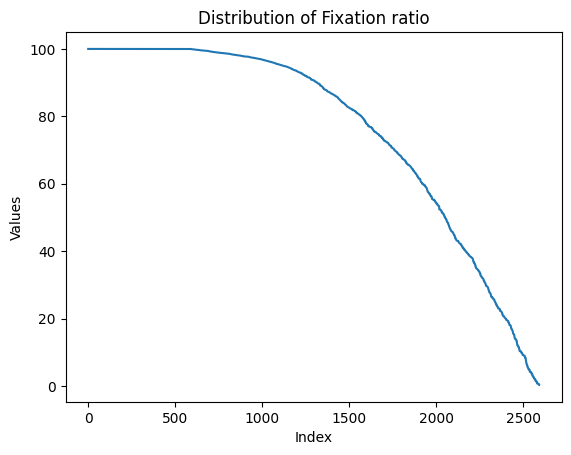

In [74]:
# inspect distributions of numerical features
feature_to_inspect = 'track_ratio'

toshow = exp_meta.sort_values(by=feature_to_inspect, ascending=False).reset_index()

plt.plot(toshow[feature_to_inspect][toshow[feature_to_inspect] < 1000])
plt.title('Distribution of Fixation ratio')
plt.xlabel('Index')
plt.ylabel('Values')
plt.show()

In [46]:
toshow[:1]

,index,participant,stimulus,track_ratio,ASD,length,fixation_ratio,saccade_ratio
0,1362,52,07 devant.jpg,100.0,False,50,1.0,0.0


In [25]:
empty_data = exp_meta[exp_meta['track_ratio'] == 0]
empty_data[empty_data['ASD'] == True]

,participant,stimulus,track_ratio,ASD,length
34,1,17 voc devant.jpg,0.0,True,66
35,1,18 aurevoir.jpg,0.0,True,66
61,10,7 devant - Copie.jpg,0.0,True,65
68,11,14 devant point chat gauche.jpg,0.0,True,51
70,11,15 devant - Copie.jpg,0.0,True,52
...,...,...,...,...,...
2861,9,9 voc devant G.jpg,0.0,True,66
2890,7,18 aurevoir.jpg,0.0,True,59
2895,7,6 devant point chien D.jpg,0.0,True,64
2896,7,7 devant - Copie.jpg,0.0,True,66


In [26]:
empty_data[empty_data['ASD'] == False]

,participant,stimulus,track_ratio,ASD,length
157,32,9 voc devant.jpg,0.0,False,57
240,38,1 coucou D.jpg,0.0,False,61
251,38,3 regard chien D.jpg,0.0,False,64
410,-1,11 yeux chat gauche.jpg,0.0,False,1094
411,-1,12 tete chat gauche.jpg,0.0,False,1141
...,...,...,...,...,...
2666,36,3 regard chien G.jpg,0.0,False,65
2667,36,4 tete chien G.jpg,0.0,False,66
2711,38,9 voc devant G.jpg,0.0,False,66
2863,-1,12 tete chat droite.jpg,0.0,False,1115


In [49]:
experiments[2].data

,Point of Regard Right X [px],Point of Regard Right Y [px],Category Right_Blink,Category Right_Saccade,Category Right_Fixation,Category Left_Blink,Category Left_Saccade,Category Left_Fixation,distance,normalized_distance
0,0.079523,0.010751,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000
1,0.079523,0.010751,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000
2,0.079523,0.010751,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000
3,0.079523,0.010751,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000
4,0.079523,0.010751,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
1127,0.750749,0.364685,0.0,1.0,0.0,0.0,1.0,0.0,142.248337,0.114665
1128,0.917373,0.381881,0.0,1.0,0.0,0.0,1.0,0.0,235.606204,0.189920
1129,0.621750,0.353591,0.0,1.0,0.0,0.0,1.0,0.0,417.825722,0.336805
1130,1.000000,0.393187,0.0,1.0,0.0,0.0,1.0,0.0,534.895172,0.431173


# model and training

In [146]:
# actual time series data
max_time = max([exp.data.shape[0] for exp in experiments])
if max_time > max_time_length:
    max_time = max_time_length


# prepare the data in df into a numpy array

def padding(df, length):
    padded = []
    for exp in df:
        # truncate data to have a maximum number of time steps
        if exp.data.shape[0] > length:
            padded.append(exp.data.values[:max_time_length])
        else:
            padded.append(np.pad(exp.data.values, ((0, length - exp.data.shape[0]), (0, 0)), mode='constant'))
    # padded = [np.pad(exp.data.values, ((0, max_time - exp.data.shape[0]), (0, 0)), mode='constant') for exp in experiments]
    data = np.stack(padded, axis=0)
    labels = np.array([1 if exp.asd else 0 for exp in df])
    return data, labels


In [147]:
# Split data into training and testing
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

def train_test_split(dfs):

    # Generate shuffled indices
    indices = np.arange(len(dfs))
    np.random.shuffle(indices)

    # Split indices for training and testing
    train_indices = indices[:int(train_ratio * len(dfs))]
    test_indices = indices[int(train_ratio * len(dfs)):]

    # splitting
    for i in train_indices: dfs[i].tag = 'train'
    for i in test_indices: dfs[i].tag = 'test'

    return dfs

In [148]:
# data loader

class loader:
    def __init__(self):
        self.current_idx = 0
        self.data = experiments

    def reset(self):
        self.current_idx = 0
    
    def next(self, mode):
        c = 0
        selected = []
        done = False
        while (c < batch_size and not done):
            if self.data[self.current_idx].tag == mode:
                selected.append(self.data[self.current_idx])
                c += 1
            self.current_idx += 1
            if self.current_idx >= len(self.data): done = True

        if c > 0: 
            x, y = padding(selected, max_time_length)
            return x, y, done

        else:
            return 'nothin', '', done
    

In [149]:
# LSTM model

seq_len = max_time_length        # Length of each sequence

criterion = nn.BCELoss()

# Define LSTM model for sequence classification
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size_fc)  # Fully connected layer for classification
        self.fc2 = nn.Linear(hidden_size_fc, output_size)  # Fully connected layer for classification

        self.pw = False

    def forward(self, x):
        # Forward pass through LSTM
        x = x.contiguous()
        out, (hn, cn) = self.lstm(x)
        out = torch.sigmoid(out[:, -1, :])
        if(self.pw): 
            print(out)
            self.pw = False
        out = self.fc1(out)
        out = self.fc2(torch.sigmoid(out))
        return torch.sigmoid(out)


In [150]:
# GRU model

seq_len = max_time_length        # Length of each sequence

criterion = nn.BCELoss()

# Define LSTM model for sequence classification
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size_fc)  # Fully connected layer for classification
        self.fc2 = nn.Linear(hidden_size_fc, output_size)  # Fully connected layer for classification
        
        self.pw = False

    def forward(self, x):
        # Forward pass through LSTM
        x = x.contiguous()
        out, _ = self.gru(x)
        out = torch.sigmoid(out[:, -1, :])
        if(self.pw): 
            print(out)
            self.pw = False
        out = self.fc1(out)
        out = self.fc2(torch.sigmoid(out))
        out = torch.sigmoid(out)
        return out

In [151]:
# model choice
model = GRUClassifier(input_size, hidden_size, num_layers, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [152]:
# [TODO] copied from gpt

# train/test split
timer.start()
experiments = train_test_split(experiments)
print('train/test split complete.')
timer.stop()

# Training the LSTM model
for epoch in range(num_epochs):

    timer.start()
    
    data_loader = loader()
    done = False
    # model.pw = True
    while not done:
        x_batch, y_batch, done = data_loader.next('train')
        if type(x_batch) == type('nothin'):
            done = True
            break
        x_batch = torch.FloatTensor(x_batch)
        y_batch = torch.FloatTensor(y_batch)
        
        # print("loading data...")
        # Reshape input to (batch_size, sequence_length, input_size)
        x_batch = x_batch.view(-1, seq_len, input_size).contiguous()
        y_batch = y_batch.view(-1, output_size).contiguous()
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # print("forward passing...")
        # Forward pass
        outputs = model(x_batch.contiguous())
        loss = criterion(outputs, y_batch)

        # print("backward passing...")
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    timer.stop()


train/test split complete.
Elapsed time: 0.00 seconds
Epoch [1/100], Loss: 0.5391
Elapsed time: 1.47 seconds
Epoch [2/100], Loss: 0.5430
Elapsed time: 1.21 seconds
Epoch [3/100], Loss: 0.5360
Elapsed time: 1.14 seconds
Epoch [4/100], Loss: 0.5094
Elapsed time: 1.15 seconds
Epoch [5/100], Loss: 0.5187
Elapsed time: 1.32 seconds
Epoch [6/100], Loss: 0.5024
Elapsed time: 1.39 seconds
Epoch [7/100], Loss: 0.4822
Elapsed time: 1.21 seconds
Epoch [8/100], Loss: 0.4761
Elapsed time: 1.20 seconds
Epoch [9/100], Loss: 0.4729
Elapsed time: 1.23 seconds
Epoch [10/100], Loss: 0.4881
Elapsed time: 1.25 seconds
Epoch [11/100], Loss: 0.4795
Elapsed time: 1.29 seconds
Epoch [12/100], Loss: 0.4769
Elapsed time: 1.15 seconds
Epoch [13/100], Loss: 0.4762
Elapsed time: 1.16 seconds
Epoch [14/100], Loss: 0.4758
Elapsed time: 1.22 seconds
Epoch [15/100], Loss: 0.4753
Elapsed time: 1.14 seconds
Epoch [16/100], Loss: 0.4752
Elapsed time: 1.19 seconds
Epoch [17/100], Loss: 0.4755
Elapsed time: 1.20 seconds
Epo

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# testing

In [ ]:
# test with training first

threshold = 0.378

# Test with new data
with torch.no_grad():
    # # Create a new sine wave sequence for testing
    # test_x = np.linspace(100, 150, 100)
    # test_y = np.sin(test_x)

    data_loader = loader()
    done = False
    predictions = []
    raw_predictions = []
    tp, fp, tn, fn = 0, 0, 0, 0
    t = 0
    f = 0
    while not done:
        test_x, test_y, done = data_loader.next('train')
        if type(test_x) == type('nothin'):
            done = True
            break
    
        test_x = torch.FloatTensor(test_x)
        test_y = torch.FloatTensor(test_y)
        test_x = test_x.view(-1, seq_len, input_size).contiguous().to(device)

        # Make predictions
        batch_pred = (model(test_x) > threshold).float().cpu()
        predictions += batch_pred
        raw_predictions += model(test_x).float().cpu()

        # record evaluation metric data
        pred = batch_pred.reshape(min(batch_size, batch_pred.shape[0]))
        tp += torch.logical_and(pred, test_y).sum()
        fp += torch.logical_and(pred, test_y.logical_not()).sum()
        tn += torch.logical_and(pred.logical_not(), test_y.logical_not()).sum()
        fn += torch.logical_and(pred.logical_not(), test_y).sum()

    # Print predictions
    print(raw_predictions)
    print(len(predictions))
    print(tp, fp, tn, fn)
    print(f'accuracy: {(tp + tn) / (tp + tn + fp + fn)}')
    print(f'sensitivity: {tp / (tp + fn)}')
    print(f'specificity: {tn / (fp + tn)}')


In [ ]:
# [TODO] copied from gpt

threshold = 0.378

# Test with new data
with torch.no_grad():
    # # Create a new sine wave sequence for testing
    # test_x = np.linspace(100, 150, 100)
    # test_y = np.sin(test_x)

    data_loader = loader()
    done = False
    predictions = []
    raw_predictions = []
    tp, fp, tn, fn = 0, 0, 0, 0
    t = 0
    f = 0
    while not done:
        test_x, test_y, done = data_loader.next('test')
        if type(test_x) == type('nothin'):
            done = True
            break
    
        test_x = torch.FloatTensor(test_x)
        test_y = torch.FloatTensor(test_y)
        test_x = test_x.view(-1, seq_len, input_size).contiguous().to(device)

        # Make predictions
        batch_pred = (model(test_x) > threshold).float().cpu()
        predictions += batch_pred
        raw_predictions += model(test_x).float().cpu()

        # record evaluation metric data
        pred = batch_pred.reshape(min(batch_size, batch_pred.shape[0]))
        tp += torch.logical_and(pred, test_y).sum()
        fp += torch.logical_and(pred, test_y.logical_not()).sum()
        tn += torch.logical_and(pred.logical_not(), test_y.logical_not()).sum()
        fn += torch.logical_and(pred.logical_not(), test_y).sum()

    # Print predictions
    print(raw_predictions)
    print(len(predictions))
    print(tp, fp, tn, fn)


In [ ]:
print(f'accuracy: {(tp + tn) / (tp + tn + fp + fn)}')
print(f'sensitivity: {tp / (tp + fn)}')
print(f'specificity: {tn / (fp + tn)}')